# Time-varying g-formula 
### Demonstration of the TimeVaryGFormula class, using an example from Keil et al. "The parametric G-formula for time-to-event data: towards intuition with a worked example" DOI: 10.1097/EDE.0000000000000160

Using this code:
   Run code through the terminal. The GvHD will be loaded from zEpid and the process of fitting the model
   will be completed. Note, this code may take awhile unless the resamples are maximum time are changed.

Two graphs (observed vs natural & natural vs prevent GvHD) are created. The Cox PH model results are printed to the terminal

#### Versions:
    Python 3.6.3
    numpy v1.14.5
    pandas v0.23.0
    lifelines v0.14.6

Code by: Paul Zivich,                                                      Last edit: 2018/08/28

## Step 0) Setting up environment

In [1]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import zepid as ze
from zepid.causal.gformula import TimeVaryGFormula

% matplotlib inline

df = ze.load_gvhd_data()
df['tomorrow'] = df['day']+1

Index(['id', 't', 't_rel', 'd_dea', 't_gvhd', 'd_gvhd', 'd_rel', 't_pla',
       'd_pla', 'age', 'male', 'cmv', 'waitdays', 'all', 'wait', 'agesq',
       'agecurs1', 'agecurs2', 't_int', 'yesterday', 'day', 'tomorrow',
       'daysq', 'daycu', 'daycurs1', 'daycurs2', 'tdiff', 'd', 'gvhd',
       'relapse', 'platnorm', 'gvhdm1', 'relapsem1', 'platnormm1', 'censeof',
       'censlost', 'daysnorelapse', 'daysnoplatnorm', 'daysnogvhd',
       'daysrelapse', 'daysplatnorm', 'daysgvhd'],
      dtype='object')


## Step 1) Initialize TimeVaryGFormula class

In [2]:
g = TimeVaryGFormula(df,  # pandas dataframe object containing data to fit to
                     idvar='id',  # unique ID for participants
                     exposure='gvhd',  # exposure column label (gvhd)
                     outcome='d',  # outcome column label (d)
                     time_in='day',  # entry time column label
                     time_out='tomorrow')  # exit time column label

## Step 2) Regression model for exposure (graph-versus-host-disease)

In [3]:
exp_m = ('all + cmv + male + age + agecurs1 + agecurs2 + platnormm1 + daysnoplatnorm + relapsem1 + daysnorelapse + '
         'day + daysq + wait')
g.exposure_model(exp_m,  # dependent variable model to predict exposure
                 restriction="g['gvhdm1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   gvhd   No. Observations:                54617
Model:                            GLM   Df Residuals:                    54603
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -477.60
Date:                Tue, 28 Aug 2018   Deviance:                       955.20
Time:                        10:23:11   Pearson chi2:                 2.30e+04
No. Iterations:                    19   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.2506      1.003     -7.226      0.000      -9.217      -5.284
all                0.6005      0.287    

## Step 3) Regresion model for outcome (death)

In [4]:
out_m = ('all + cmv + male + age  + agesq + day + daysq + gvhd + platnorm + daysnoplatnorm + relapse + daysnorelapse +'
         ' daycu + wait + day*gvhd + daysq*gvhd + daycu*gvhd')
g.outcome_model(out_m)  # dependent variable model to predict outcome

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      d   No. Observations:               108714
Model:                            GLM   Df Residuals:                   108696
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -565.43
Date:                Tue, 28 Aug 2018   Deviance:                       1130.9
Time:                        10:23:17   Pearson chi2:                 8.99e+04
No. Iterations:                    13   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.3353      0.943     -7.777      0.000      -9.184      -5.487
all               -0.0493      0.291    

## Step 4) Regression model for covariate (normal platelets count)

In [5]:
prp_m = 'all + cmv + male + age + agecurs1 + agecurs2 + gvhdm1 + daysgvhd + daysnorelapse + wait'
prp_recode = ("g['platnorm'] = np.where(g['platnormm1']==1,1,g['platnorm']);"
              "g['daysnoplatnorm'] = np.where(g['platnorm']==0,g['daysnoplatnorm']+1,g['daysnoplatnorm']);"
              "g['daysplatnorm'] = np.where(g['platnorm']==0,g['daysplatnorm'],g['daysplatnorm']+1);")
g.add_covariate_model(label=1,  # order to fit the covariate model
                      covariate='platnorm',  # covariate to predict
                      model=prp_m,  # dependent variable model to predict covariate (platnorm)
                      recode=prp_recode,  # recoding process to execute each loop
                      var_type='binary',  # covariate variable type
                      restriction="g['platnormm1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:               platnorm   No. Observations:                 6842
Model:                            GLM   Df Residuals:                     6831
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -535.65
Date:                Tue, 28 Aug 2018   Deviance:                       1071.3
Time:                        10:23:20   Pearson chi2:                 4.61e+03
No. Iterations:                    13   Covariance Type:             nonrobust
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.7715      0.640     -9.025      0.000      -7.025      -4.518
all              -0.0710      0.233     -0.

## Step 5) Regression model for covariate (probability of relapse)

In [6]:
prr_m = ('all + cmv + male + age + agecurs1 + agecurs2 + gvhdm1 +  daysgvhd + platnormm1 + daysnoplatnorm + day + '
         'daysq + wait')
relapse_recode = ("g['relapse'] = np.where(g['relapsem1']==1,1,g['relapse']);"
                  "g['daysnorelapse'] = np.where(g['relapse']==0,g['daysnorelapse']+1,g['daysnorelapse']);"
                  "g['daysrelapse'] = np.where(g['relapse']==0,g['daysrelapse'],g['daysrelapse']+1);")
g.add_covariate_model(label=2,  # order to fit the covariate model
                      covariate='relapse',  # covariate to predict
                      model=prr_m,  # dependent variable model to predict covariate (relapse)
                      recode=relapse_recode,  # recoding process to execute each loop
                      var_type='binary',  # covariate variable type
                      restriction="g['relapsem1']==0")  # restricting for ITT

                 Generalized Linear Model Regression Results                  
Dep. Variable:                relapse   No. Observations:               100930
Model:                            GLM   Df Residuals:                   100916
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.76
Date:                Tue, 28 Aug 2018   Deviance:                       691.51
Time:                        10:23:27   Pearson chi2:                 7.56e+04
No. Iterations:                    15   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.8681      1.308     -5.250      0.000      -9.432      -4.304
all                0.5865      0.391    

## Step 6) Regression model for covariate (censoring)
Censoring model is only important for the natural course model

In [7]:
cen_m = 'all + cmv + male + age + agesq + daysgvhd + daysnoplatnorm + daysnorelapse + day + daysq + daycu + wait'
g.add_covariate_model(label=3,  # order to fit the covariate model
                      covariate='censlost',  # covariate to predict
                      model=cen_m,  # dependent variable model to predict covariate (relapse)
                      var_type='binary')  # covariate variable type

                 Generalized Linear Model Regression Results                  
Dep. Variable:               censlost   No. Observations:               108714
Model:                            GLM   Df Residuals:                   108701
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -309.40
Date:                Tue, 28 Aug 2018   Deviance:                       618.80
Time:                        10:23:33   Pearson chi2:                 8.77e+04
No. Iterations:                    14   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -9.8879      2.242     -4.409      0.000     -14.283      -5.493
all                0.7590      0.448    

## Step 7) Estimating natural course

In [8]:
g.fit(treatment="((g['gvhd']==1) | (g['gvhdm1']==1))",  # treatment strategy (ITT natural course)
      lags={'platnorm': 'platnormm1',  # lagging certain variables at end of each loop
            'relapse': 'relapsem1',
            'gvhd': 'gvhdm1'},
      sample=13700,  # number to resample from the population for Monte Carlo, less than original to avoid MemoryError
      t_max=1825,  # maximum time to simulate until (5 years)
      in_recode=("g = g.loc[g['censlost']==0].copy();"  # variable recoding to execute at start of loop
                 "g['daysq'] = g['day']**2;"
                 "g['daycu'] = g['day']**3;"),
      out_recode=("g['daysnogvhd'] = np.where(g['gvhd']==0,g['daysnogvhd']+1,g['daysnogvhd']);"  # recoding at end
                  "g['daysgvhd'] = np.where(g['gvhd']==0,g['daysgvhd'],g['daysgvhd']+1);"))

Note: above code took about 5 minutes to run on Python 3.6 64bit


### Step 7a) Comparing natural course to observed data

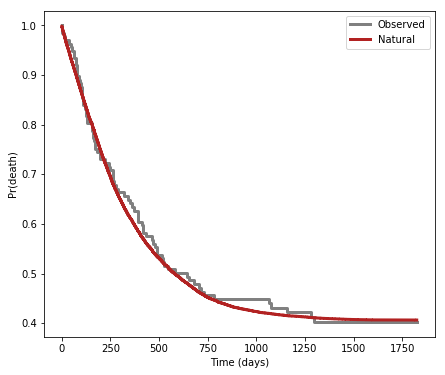

In [9]:
# G-formula predictions
gf = g.predicted_outcomes
gf['d'] = np.where(gf['censlost'] == 1, 0, gf['d'])  # resolving any potential censor conflicts
gfs = gf.loc[gf.uid_g_zepid != gf.uid_g_zepid.shift(-1)].copy()  # getting last observation
kmn = KaplanMeierFitter()  # fitting Kaplan-Meier
kmn.fit(durations=gfs['day'], event_observed=gfs['d'])

# Observed data (extracting last observation)
df.sort_values(by=['id', 'day'])
dfs = df.loc[df.id != df.id.shift(-1)].copy()
kmo = KaplanMeierFitter()
kmo.fit(durations=dfs['day'], event_observed=dfs['d'])

# Creating plots
plt.figure(figsize=(7,6))
plt.step(kmo.event_table.index, kmo.survival_function_, c='gray', where='post', label='Observed', linewidth=3)
plt.step(kmn.event_table.index, kmn.survival_function_, c='firebrick', where='post', label='Natural', linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Pr(death)')
plt.legend()
plt.show()

## Step 8) Estimating no graph-versus-host-disease 

In [14]:
g.fit(treatment="none",
      lags={'platnorm': 'platnormm1',
            'relapse': 'relapsem1',
            'gvhd': 'gvhdm1'},
      sample=13700,  # number to resample from the population for Monte Carlo
      t_max=1825,  # maximum time to simulate until (5 years)
      in_recode=("g['daysq'] = g['day']**2;"
                 "g['daycu'] = g['day']**3;"),
      out_recode=("g['daysnogvhd'] = np.where(g['gvhd']==0,g['daysnogvhd']+1,g['daysnogvhd']);"
                  "g['daysgvhd'] = np.where(g['gvhd']==0,g['daysgvhd'],g['daysgvhd']+1);"))

## Step 9) Comparison of natural course to preventing all GvHD

In [15]:
# Fitting Kaplan Meier for the prevent all GvHD data
gfn = g.predicted_outcomes.copy()
gfns = gfn.loc[gfn.uid_g_zepid != gfn.uid_g_zepid.shift(-1)].copy()
kmp = KaplanMeierFitter()
kmp.fit(durations=gfns['day'], event_observed=gfns['d'])

# Setting up pandas dataframe for lifelines.CoxPHFitter
rfn = pd.DataFrame()  # Natural course data
rfn['event'] = gfs['d']
rfn['time'] = gfs['day']
rfn['exp'] = 1

rfp = pd.DataFrame()  # Creating df for CoxPHFitter
rfp['event'] = gfns['d']
rfp['time'] = gfns['day']
rfp['exp'] = 0
rf = rfn.append(rfp, ignore_index=True, sort=False)

### Step 9a) Generating survival curve plots

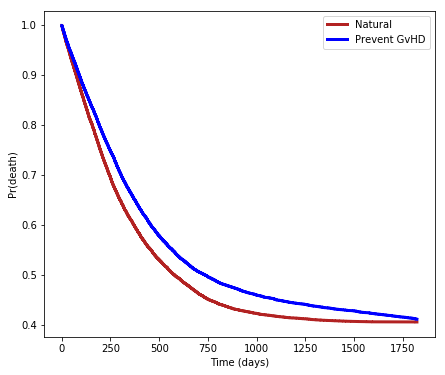

In [16]:
plt.figure(figsize=(7,6))
plt.step(kmn.event_table.index, kmn.survival_function_, c='firebrick', where='post', label='Natural', linewidth=3)
plt.step(kmp.event_table.index, kmp.survival_function_, c='blue', where='post', label='Prevent GvHD', linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Pr(death)')
plt.legend()
plt.show()

### Step 9b) Estimating Hazard Ratio

In [20]:
cph = CoxPHFitter()
cph.fit(rf, duration_col='time', event_col='event')
print('Hazard Ratio:', round(np.exp(cph.hazards_['exp'][0]), 1))

Hazard Ratio: 1.1
